# Import

In [2]:
import json
import trimesh
import numpy as np
import quaternion
import os
import open3d as o3d

import pandas as pd 
import plotly.graph_objs as go
import plotly.io as pio

cat2color_map = {
    'sofa': 'rgba(244, 22, 100, 0.8)',    # 粉红色
    'table': 'rgba(22, 244, 100, 0.8)',   # 绿色
    'chair': 'rgba(100, 22, 244, 0.8)',   # 紫色
    'bed': 'rgba(244, 100, 22, 0.8)',      # 橙色
    'bookshelf': 'rgba(22, 100, 244, 0.5)',  # 蓝色
    'cabinet': 'rgba(100, 244, 22, 0.5)'     # 青色
}

pcd_color = "rgba(10, 10, 10, 0.5)"

def get_info_from_latent_name(l_name):
    # input should be like: 1a4a8592046253ab5ff61a3a2a0e2484_scene0484_00_ins_1.pth
    l_name = os.path.basename(l_name)
    latent_name = l_name.split(".")[0]
    scene = latent_name.split("_")[1]+"_"+latent_name.split("_")[2]
    ins_id = latent_name.split("_")[-1]
    obj_id = latent_name.split("_")[0]
    return scene, ins_id, obj_id

def load_pcd_vis(pcd_path,pcd_name=None,sub_sample=50000) -> np.ndarray:
    _, file_extension = os.path.splitext(pcd_path)
    if file_extension == ".pcd":
        pcd = o3d.io.read_point_cloud(pcd_path)
        point_clouds_data = np.asarray(pcd.points)
    elif file_extension == ".txt":
        point_clouds_data = np.loadtxt(pcd_path)
    elif file_extension == ".npy":
        point_clouds_data = np.load(pcd_path)
    else:
        raise NotImplementedError
    
    N = point_clouds_data.shape[0]
    point_clouds_data = point_clouds_data[np.random.choice(N, sub_sample, replace=True), :]
    
    x = point_clouds_data[:, 0]
    y = point_clouds_data[:, 1]
    z = point_clouds_data[:, 2]
    trace = go.Scatter3d(x=x, y=y, z=z, 
            mode='markers',     
            marker=dict(
                size=0.5,  # Adjust the size of the markers here
                color=pcd_color  # Set the color you want (e.g., light blue)
            ),
            name=pcd_name)
    return trace

def plotly_mesh3d_to_trimesh(plotly_mesh3d):
    """
    将Plotly Mesh3d对象转换为trimesh.Trimesh对象。
    
    参数:
        plotly_mesh3d (plotly.graph_objs.Mesh3d): Plotly Mesh3d对象。
        
    返回:
        trimesh.Trimesh: 转换后的trimesh对象。
    """
    # 从Plotly Mesh3d对象提取顶点坐标
    vertices = np.column_stack((plotly_mesh3d.x, plotly_mesh3d.y, plotly_mesh3d.z))
    
    # 从Plotly Mesh3d对象提取面
    faces = np.column_stack((plotly_mesh3d.i, plotly_mesh3d.j, plotly_mesh3d.k))
    
    # 创建trimesh.Trimesh对象
    trimesh_obj = trimesh.Trimesh(vertices=vertices, faces=faces)
    
    return trimesh_obj
    
def BoundingCubeNormalization(mesh,buffer=1.03):
    """
    transferred from deepsdf preprocessing
    input: mesh: trimesh.load
    """
    vertices = np.array(mesh.vertices)
    faces = np.array(mesh.faces)

    xmax = vertices[:,0].max()
    ymax = vertices[:,1].max()
    zmax = vertices[:,2].max()

    xmin = vertices[:,0].min()
    ymin = vertices[:,1].min()
    zmin = vertices[:,2].min()

    xcenter = (xmax+xmin)/2.0
    ycenter = (ymax+ymin)/2.0
    zcenter = (zmax+zmin)/2.0

    vertices[:,0] -= xcenter
    vertices[:,1] -= ycenter 
    vertices[:,2] -= zcenter

    norms = np.linalg.norm(vertices, axis=1)

    max_dist = norms.max()
    max_dist *= buffer

    vertices /= max_dist

    x, y, z = vertices.T  # Transposed for easier unpacking
    i, j, k = faces.T  # Unpack faces

    # if mesh_color is None:
    mesh_color = "rgba(244,22,100,0.5)"
    mesh_name = "normalized"

    mesh_normalized = go.Mesh3d(
        x=x, y=y, z=z,
        i=i, j=j, k=k,
        opacity=0.5,
        color=mesh_color,
        name=mesh_name
    )
    
    return mesh_normalized, 1./max_dist, np.array([xcenter,ycenter,zcenter])

def BoundingCubeDeNormalization(mesh, max_dists_d, centers, buffer=1.03):
    """
    transferred from deepsdf preprocessing
    input: mesh: trimesh.load
    """
    vertices = np.array(mesh.vertices)
    faces = np.array(mesh.faces)

    max_dist = 1./max_dists_d

    max_dist /= buffer

    vertices *= max_dist

    vertices[:,0] += centers[0]
    vertices[:,1] += centers[1]
    vertices[:,2] += centers[2]

    x, y, z = vertices.T  # Transposed for easier unpacking
    i, j, k = faces.T  # Unpack faces

    # if mesh_color is None:
    mesh_color = "rgba(244,22,100,0.5)"
    mesh_name = "unnormalized"

    mesh_unnormalized = go.Mesh3d(
        x=x, y=y, z=z,
        i=i, j=j, k=k,
        opacity=0.5,
        color=mesh_color,
        name=mesh_name
    )
    
    return mesh_unnormalized

def quaternion_list2rotmat(quant_list: list, format="xyzw"):
    assert len(quant_list) == 4, "Quaternion needs 4 elements"
    if format=="xyzw":
        q = np.quaternion(quant_list[0], quant_list[1], quant_list[2], quant_list[3])
    elif format=="wxyz":
        q = np.quaternion(quant_list[1], quant_list[2], quant_list[3], quant_list[0])
    R = quaternion.as_rotation_matrix(q)
    return R

def mesh_apply_rts(mesh, rotation_mat_c2w=None, translation_c2w=None, scale_c2w=None, mesh_name=None, mesh_color=None):
    vertices = np.array(mesh.vertices)
    faces = np.array(mesh.faces)
    
    
    if rotation_mat_c2w is None:
    # Apply rotation
    # pcd_meshcoord = (np.linalg.inv(gt_rotation_mat_c2w) @ (pcd_world - gt_translation_c2w[np.newaxis, :]).T).T
        transformed_vertices = vertices
    else:
        transformed_vertices = (rotation_mat_c2w @ vertices.T).T + translation_c2w[np.newaxis, :]
    
    x, y, z = transformed_vertices.T  # Transposed for easier unpacking
    i, j, k = faces.T  # Unpack faces

    if mesh_color is None:
        mesh_color = "rgba(244,22,100,0.5)"

    mesh_transformed = go.Mesh3d(
        x=x, y=y, z=z,
        i=i, j=j, k=k,
        opacity=0.5,
        color=mesh_color,
        name=mesh_name
    )
    return mesh_transformed

def mesh_load(mesh_path, scale_c2w=None, rotation_quat_wxyz=None, translation_c2w=None,mesh_name=None):
    # 从文件加载网格数据
    file_suffix = mesh_path.split(".")[-1]
    if file_suffix == "obj":
        with open(mesh_path, 'r') as file:
            lines = file.readlines()

        vertices = []
        faces = []

        for line in lines:
            if line.startswith('v '):
                vertex = line.split()[1:]
                vertices.append([float(vertex[0]), float(vertex[1]), float(vertex[2])])
            elif line.startswith('f '):
                face = line.split()[1:]
                face_indices = [int(idx.split('/')[0]) - 1 for idx in face]
                faces.append(face_indices)

        mesh = go.Mesh3d(x=[v[0] for v in vertices], y=[v[1] for v in vertices], z=[v[2] for v in vertices],
                        i=[f[0] for f in faces], j=[f[1] for f in faces], k=[f[2] for f in faces], name=mesh_name)
        return mesh

    elif file_suffix == "ply":
        from plyfile import PlyData

        # 从PLY文件加载网格数据
        plydata = PlyData.read(mesh_path)

        # 提取顶点坐标
        vertices = np.array([list(vertex) for vertex in plydata['vertex'].data])

        # 提取面数据
        faces = np.array(plydata['face'].data['vertex_indices'])
        faces = np.array([list(row) for row in faces])

        # 创建网格图形对象
        mesh = go.Mesh3d(x=vertices[:, 0], y=vertices[:, 1], z=vertices[:, 2], i=faces[:, 0], j=faces[:, 1], k=faces[:, 2], name=mesh_name)
        return mesh

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 汇总补全结果

## diff-ddit

In [3]:
test_pred_path = {
    "sofa":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_sofa_train_noneighbor/output/69999/test/mesh/Meshes",
    "table":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_table_train_noneighbor/output/50999/test/mesh/Meshes",
    # "chair":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddi"t_stage2_diff_cond_chair_train_neighbor/output/18999/test/mesh/Meshes", #TO BE CORRECT
    "chair":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_chair_train_noneighbor/output/18999/test/mesh/oldMeshes",
    "bed":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_bed_train_noneighbor/output/55999/test/mesh",
    "bookshelf":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_bookshelf_train_noneighbor/output/23999/test/mesh",
    "cabinet":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_cabinet_train_noneighbor/output/23999/test/mesh"
}

val_pred_path = {
    "sofa":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_sofa_train_noneighbor/output/69999/val/mesh/Meshes",
    "table":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_table_train_noneighbor/output/50999/val/mesh",
    # "chair":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_chair_train_neighbor/output/18999/val/mesh/Meshes", #TO BE CORRECT
    "chair":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_chair_train_noneighbor/output/18999/val/mesh/Meshes",
    "bed":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_bed_train_noneighbor/output/55999/val/mesh",
    "bookshelf":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_bookshelf_train_noneighbor/output/23999/val/mesh",
    "cabinet":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_cabinet_train_noneighbor/output/23999/val/mesh"
}

all_list_diff = {}
category_list = {}
# statis_dict = pd.DataFrame(columns=list(test_pred_path.keys()))
statis_dict = pd.DataFrame(columns=["scene"]+list(test_pred_path.keys()))
statis_dict.set_index("scene", inplace=True)

for key,val in test_pred_path.items():
    for mesh in os.listdir(val):
        basename = mesh.split(".")[0]
        all_list_diff[basename] = (key,os.path.join(val,mesh))

        scene_name, ins_id, obj_id = get_info_from_latent_name(basename)

        try:
            statis_dict.loc[scene_name, key] += 1
        except:
            new_row = {"scene":scene_name, "sofa":0, "table":0, "chair":0, "bed":0, "bookshelf":0, "cabinet":0}
            statis_dict.loc[scene_name] = new_row
            statis_dict.loc[scene_name, key] += 1

for key,val in val_pred_path.items():
    for mesh in os.listdir(val):
        basename = mesh.split(".")[0]
        all_list_diff[basename] = (key,os.path.join(val,mesh))

        scene_name, ins_id, obj_id = get_info_from_latent_name(basename)

        try:
            statis_dict.loc[scene_name, key] += 1
        except:
            new_row = {"scene":scene_name, "sofa":0, "table":0, "chair":0, "bed":0, "bookshelf":0, "cabinet":0}
            statis_dict.loc[scene_name] = new_row
            statis_dict.loc[scene_name, key] += 1


all_list_diff

{'f98615e51a596fc5c05575120a46cd3b_scene0394_00_ins_8': ('sofa',
  '/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_sofa_train_noneighbor/output/69999/test/mesh/Meshes/f98615e51a596fc5c05575120a46cd3b_scene0394_00_ins_8.ply.ply'),
 '7ae657b39aa2be68ccd1bcd57588acf8_scene0362_01_ins_3': ('sofa',
  '/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_sofa_train_noneighbor/output/69999/test/mesh/Meshes/7ae657b39aa2be68ccd1bcd57588acf8_scene0362_01_ins_3.ply.ply'),
 '3746c2c38faaec395304a08899f58b0b_scene0312_01_ins_9': ('sofa',
  '/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_sofa_train_noneighbor/output/69999/test/mesh/Meshes/3746c2c38faaec395304a08899f58b0b_scene0312_01_ins_9.ply.ply'),
 'e877f5881c54551a2665f68ebc337f05_scene0547_01_ins_1': ('sofa',
  '/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_sofa_train_noneighbor/output/69999/test

In [4]:
statis_dict

,sofa,table,chair,bed,bookshelf,cabinet
scene,,,,,,
scene0394_00,1,3,0,0,1,0
scene0362_01,1,0,0,0,0,0
scene0312_01,1,0,0,0,0,0
scene0547_01,1,0,3,0,1,2
scene0312_02,1,0,6,0,0,0
...,...,...,...,...,...,...
scene0515_00,0,0,0,0,0,1
scene0445_00,0,0,0,0,0,1
scene0338_02,0,0,0,0,0,1


## DDIT

In [4]:
test_pred_path = {
    "sofa":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_sofa/output/999/test/mesh/Meshes",
    "table":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_table/output/999/test/mesh/Meshes",
    # "chair":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddi"t_stage2_diff_cond_chair_train_neighbor/output/18999/test/mesh/Meshes", #TO BE CORRECT
    "chair":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_chair/output/999/test/mesh/Meshes",
    "bed":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_bed/output/999/test/mesh",
}

val_pred_path = {
    "sofa":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_sofa/output/999/val/mesh",
    "table":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_table/output/999/val/mesh/Meshes",
    # "chair":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_chair_train_neighbor/output/18999/val/mesh/Meshes", #TO BE CORRECT
    "chair":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_chair/output/999/val/mesh",
    "bed":"/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_bed/output/999/val/mesh",
}
all_list_ddit = {}

for key,val in test_pred_path.items():
    for mesh in os.listdir(val):
        basename = mesh.split(".")[0]
        all_list_ddit[basename] = (key,os.path.join(val,mesh))

for key,val in val_pred_path.items():
    for mesh in os.listdir(val):
        basename = mesh.split(".")[0]
        all_list_ddit[basename] = (key,os.path.join(val,mesh))

all_list_ddit

{'f98615e51a596fc5c05575120a46cd3b_scene0394_00_ins_8': ('sofa',
  '/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_sofa/output/999/val/mesh/f98615e51a596fc5c05575120a46cd3b_scene0394_00_ins_8.ply.ply'),
 '7ae657b39aa2be68ccd1bcd57588acf8_scene0362_01_ins_3': ('sofa',
  '/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_sofa/output/999/val/mesh/7ae657b39aa2be68ccd1bcd57588acf8_scene0362_01_ins_3.ply.ply'),
 '3746c2c38faaec395304a08899f58b0b_scene0312_01_ins_9': ('sofa',
  '/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_sofa/output/999/val/mesh/3746c2c38faaec395304a08899f58b0b_scene0312_01_ins_9.ply.ply'),
 'e877f5881c54551a2665f68ebc337f05_scene0547_01_ins_1': ('sofa',
  '/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_sofa/output/999/val/mesh/e877f5881c54551a2665f68ebc337f05_scene0547_01_ins_1.ply.ply'),
 'fb74336a6192c4787afee304cce81d6f_scene0312_02_ins_9': ('sofa',
  '/sto

# 确定可用场景

ddit文章使用场景

scene0050_00
scene0066_00
scene0467_00


In [4]:
import os

sofas_root = "/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_sofa_train_noneighbor/output/69999/test/mesh/Meshes"
chairs_root = "/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_chair_train_noneighbor/output/18999/test/mesh/oldMeshes"
beds_root = "/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_bed_train_noneighbor/output/55999/test/mesh"
tables_root = "/storage/user/huju/transferred/ws_dditnach/Diffusion-SDF/config/ddit_stage2_diff_cond_table_train_noneighbor/output/50999/test/mesh/Meshes"

bookshelfs_root = 

In [15]:
scene_name2check = "scene0050_00"

result_sofa = []
scenes_sofa = []
for file in os.listdir(sofas_root):
    base_name = os.path.basename(file).split(".")[0]
    mesh_id, scene1, scene2, _,  obj_id = base_name.split(".")[0].split("_")
    mesh_scene_name=scene1+"_"+scene2
    if mesh_scene_name == scene_name2check:
        result.append(file)
    
    scenes_sofa.append(mesh_scene_name)
result_sofa

[]

In [16]:
result_chair = []
scenes_chair = []
for file in os.listdir(chairs_root):
    base_name = os.path.basename(file).split(".")[0]
    mesh_id, scene1, scene2, _,  obj_id = base_name.split(".")[0].split("_")
    mesh_scene_name=scene1+"_"+scene2
    if mesh_scene_name == scene_name2check:
        result_chair.append(file)
    scenes_chair.append(mesh_scene_name)

result_chair

[]

In [17]:
result_table = []
scenes_table = []
for file in os.listdir(tables_root):
    base_name = os.path.basename(file).split(".")[0]
    mesh_id, scene1, scene2, _,  obj_id = base_name.split(".")[0].split("_")
    mesh_scene_name=scene1+"_"+scene2
    if mesh_scene_name == scene_name2check:
        result_table.append(file)
    scenes_table.append(mesh_scene_name)

print(result_table)

[]


In [18]:
result_bed = []
scenes_bed = []
for file in os.listdir(beds_root):
    base_name = os.path.basename(file).split(".")[0]
    mesh_id, scene1, scene2, _,  obj_id = base_name.split(".")[0].split("_")
    mesh_scene_name=scene1+"_"+scene2
    if mesh_scene_name == scene_name2check:
        result_bed.append(file)
    scenes_bed.append(mesh_scene_name)

print(result_bed)

[]


In [20]:
set(scenes_sofa).intersection(set(scenes_table))

{'scene0181_00'}

In [21]:
set(scenes_sofa).intersection(set(scenes_chair))

{'scene0517_01', 'scene0582_00'}

In [22]:
set(scenes_sofa).intersection(set(scenes_bed))

set()

In [23]:
set(scenes_chair).intersection(set(scenes_table))

{'scene0041_01',
 'scene0056_01',
 'scene0233_01',
 'scene0248_00',
 'scene0279_01',
 'scene0332_01',
 'scene0362_03',
 'scene0367_01',
 'scene0529_00',
 'scene0547_00',
 'scene0658_00'}

In [24]:
set(scenes_chair).intersection(set(scenes_bed))

{'scene0055_01', 'scene0656_03'}

In [25]:
set(scenes_table).intersection(set(scenes_bed))

{'scene0426_03'}

In [32]:
from collections import Counter, defaultdict

def count_items_in_lists(*lists):
    """
    Count the occurrences of items in multiple lists, keeping track of their names and counts in each list.

    Parameters:
    *lists: Multiple lists to count items from.

    Returns:
    A dictionary where keys are item names and values are dictionaries with counts in each list.
    """
    list_counters = [Counter(lst) for lst in lists]
    total_counter = defaultdict(lambda: [0] * len(lists))

    for i, counter in enumerate(list_counters):
        for item, count in counter.items():
            total_counter[item][i] = count

    return total_counter

res = count_items_in_lists(scenes_sofa, scenes_chair, scenes_table, scenes_bed)
for item, counts in res.items():
    print(f"Item {item} appears in the lists with counts: {counts}")


Item scene0394_00 appears in the lists with counts: [1, 0, 0, 0]
Item scene0362_01 appears in the lists with counts: [1, 0, 0, 0]
Item scene0312_01 appears in the lists with counts: [1, 0, 0, 0]
Item scene0547_01 appears in the lists with counts: [1, 0, 0, 0]
Item scene0312_02 appears in the lists with counts: [1, 0, 0, 0]
Item scene0701_02 appears in the lists with counts: [3, 0, 0, 0]
Item scene0540_02 appears in the lists with counts: [1, 0, 0, 0]
Item scene0651_02 appears in the lists with counts: [1, 0, 0, 0]
Item scene0177_01 appears in the lists with counts: [1, 0, 0, 0]
Item scene0022_01 appears in the lists with counts: [1, 0, 0, 0]
Item scene0344_00 appears in the lists with counts: [5, 0, 0, 0]
Item scene0181_00 appears in the lists with counts: [1, 0, 2, 0]
Item scene0022_00 appears in the lists with counts: [1, 0, 0, 0]
Item scene0166_00 appears in the lists with counts: [1, 0, 0, 0]
Item scene0591_01 appears in the lists with counts: [1, 0, 0, 0]
Item scene0517_01 appears

In [34]:
len(res.items())

221

In [ ]:
Item scene0248_00 appears in the lists with counts: [0, 8, 2, 0]

Item scene0517_01 appears in the lists with counts: [1, 3, 0, 0]

# scene0056_01
Item scene0056_01 appears in the lists with counts: [0, 4, 5, 0] 可以用，场景只有桌椅

In [28]:
data_root = "/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA"
json_version = "json_files_v5"
traj_file = None

scene_name = "scene0056_01"

# LAYOUT_VIS=True
LAYOUT_VIS=False

MESH_VIS=True
MESH_PRED_VIS=False

# SEGPCD_VIS=True
# COMPLETE_PCD_VIS=False

SEGPCD_VIS=False
COMPLETE_PCD_VIS=True

M = 50000

vis_data = []
mesh_paths = []

if COMPLETE_PCD_VIS:
    pcd_path = os.path.join(data_root,"ScanARCW/complete_pcd/{}/{}.txt".format(scene_name,scene_name))
    data = np.loadtxt(pcd_path)
    N = data.shape[0]
    data = data[np.random.choice(N, M, replace=False), :]
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]
    complete_pcd = go.Scatter3d(x=x, y=y, z=z, 
            mode='markers',     
            marker=dict(
                size=0.5,  # Adjust the size of the markers here
                color='rgba(35, 35, 250, 0.8)'  # Set the color you want (e.g., light blue)
            ),
            name="scene points")
    vis_data.append(complete_pcd)
        

# json_file = "/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/json_files_v2/{}.json".format(scene_name)
json_file = os.path.join(data_root,"ScanARCW",json_version,"{}.json".format(scene_name))

with open(json_file, 'r') as file:
    raw_json = json.load(file)
for scene_id in raw_json.keys():
    instances_data = raw_json[scene_id]["instances"]
    for instance_id in instances_data.keys():
        instance_data = instances_data[instance_id]
        if not instance_data:
            print("The dictionary is empty.")
            continue
        if instance_data['category_name'] == "layout" and (not LAYOUT_VIS):
            print("layout is skipped!")
            continue
        gt_translation_c2w = np.array(instance_data["gt_translation_c2w"]) # 3,
        mesh_path = os.path.join(data_root,instance_data["gt_scaled_canonical_mesh"])
        if instance_data.get("gt_rotation_quat_xyzw_c2w",False):
            print(mesh_path)
            gt_rotation_mat_c2w = quaternion_list2rotmat(instance_data["gt_rotation_quat_xyzw_c2w"],format="xyzw")
            if instance_data['category_id'] in ["1","2","3","4"]:
                print(instance_data['category_id'])
                gt_rotation_mat_c2w = quaternion_list2rotmat(instance_data["gt_rotation_quat_xyzw_c2w"],format="wxyz")
        elif instance_data.get("gt_rotation_quat_wxyz_c2w",False):
            print(mesh_path)
            gt_rotation_mat_c2w = quaternion_list2rotmat(instance_data["gt_rotation_quat_wxyz_c2w"])
        else:
            print("skipped!")
            continue
        
        # mesh = mesh_load(mesh_path)
        mesh_paths.append(mesh_path)
        mesh = trimesh.load(mesh_path)
        basename = os.path.basename(os.path.dirname(mesh_path))
        mesh_normalied, scale, centers = BoundingCubeNormalization(mesh,buffer=1.03)
        mesh = mesh_apply_rts(mesh, mesh_name=basename, rotation_mat_c2w=gt_rotation_mat_c2w, translation_c2w=gt_translation_c2w, scale_c2w=None)
        if MESH_VIS:
            vis_data.append(mesh)
        
        
        # 加载gt mesh计算normal参数然后反向加载到重建结果上再加变换回场景
        if basename in all_list.keys():
            mesh_pred_path = all_list[basename]
            mesh_pred = trimesh.load(mesh_pred_path)
            mesh_pred_denormalized = BoundingCubeDeNormalization(mesh_pred, scale, centers)
            mesh_pred_denormalized = plotly_mesh3d_to_trimesh(mesh_pred_denormalized)
            mesh_pred_denormalized = mesh_apply_rts(mesh_pred_denormalized, mesh_name="pred_"+basename, rotation_mat_c2w=gt_rotation_mat_c2w, translation_c2w=gt_translation_c2w, scale_c2w=None)
            if MESH_PRED_VIS:
                vis_data.append(mesh_pred_denormalized)

        if SEGPCD_VIS:
            try:
                seg_pcd_path = os.path.join(data_root,instance_data["segmented_cloud"])
                seg_pcd = load_pcd_vis( seg_pcd_path, sub_sample=int( M/len(instances_data.keys()) ) )
                seg_pcd.name = "pcd_{}".format(instance_id)
                vis_data.append(seg_pcd)
            except Exception as e:
                print(e)
                continue
        # break
        # pcd_meshcoord = (np.linalg.inv(gt_rotation_mat_c2w) @ (pcd_world - gt_translation_c2w[np.newaxis, :]).T).T

layout = go.Layout(scene=dict(
        aspectmode='data',  # Set the aspect ratio to 'cube' for equal scales
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
    ),)

fig = go.Figure(data=vis_data, layout=layout)
# fig.show()

SyntaxError: invalid syntax (3470518538.py, line 88)

filter train scenes

# scene0248_00

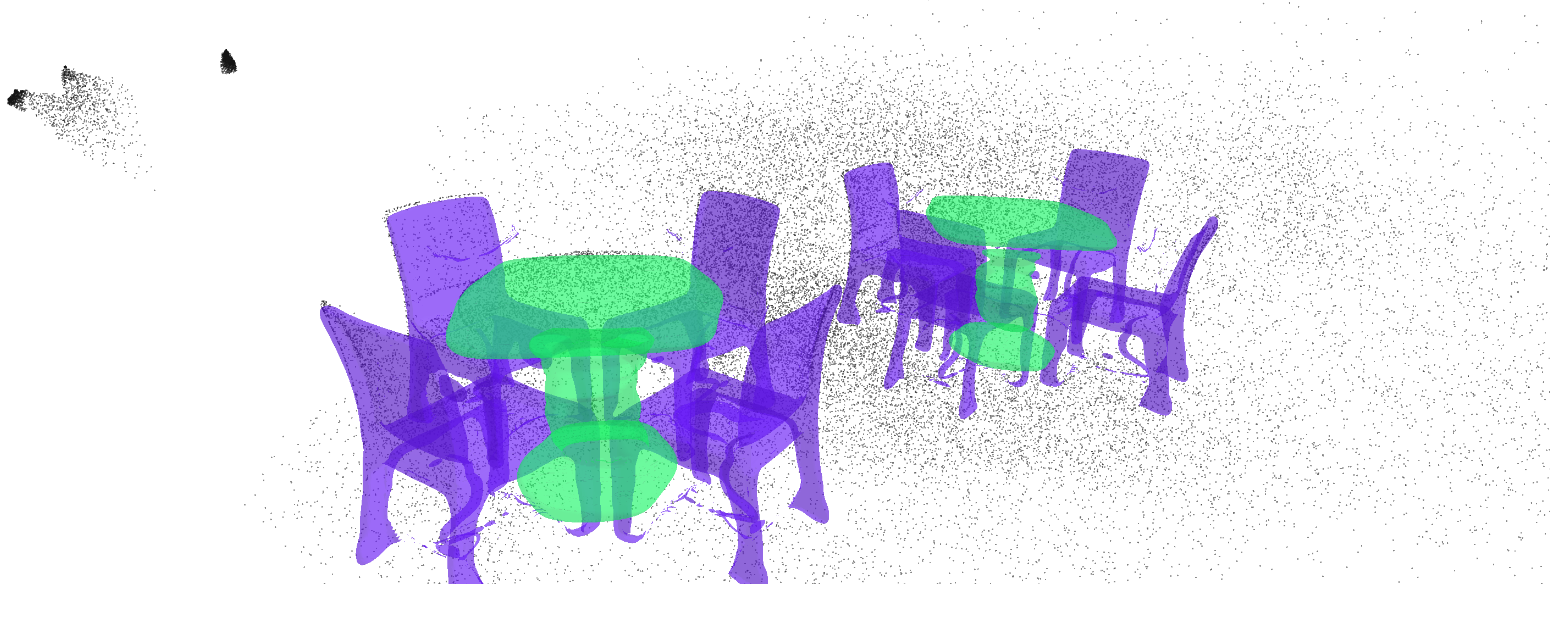

## diff

In [5]:
data_root = "/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA"
json_version = "json_files_v5"
traj_file = None

scene_name = "scene0248_00"

# LAYOUT_VIS=True
LAYOUT_VIS=False

MESH_VIS=True
MESH_PRED_VIS=False
MESH_VIS=False
MESH_PRED_VIS=True

# SEGPCD_VIS=True
# COMPLETE_PCD_VIS=False
SEGPCD_VIS=False
COMPLETE_PCD_VIS=True

M = 50000

vis_data = []
mesh_paths = []

if COMPLETE_PCD_VIS:
    pcd_path = os.path.join(data_root,"ScanARCW/complete_pcd/{}/{}.txt".format(scene_name,scene_name))
    data = np.loadtxt(pcd_path)
    N = data.shape[0]
    data = data[np.random.choice(N, M, replace=False), :]
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]
    complete_pcd = go.Scatter3d(x=x, y=y, z=z, 
            mode='markers',     
            marker=dict(
                size=0.8,  # Adjust the size of the markers here
                color=pcd_color  # Set the color you want (e.g., light blue)
            ),
            name="scene points")
    vis_data.append(complete_pcd)
        

# json_file = "/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/json_files_v2/{}.json".format(scene_name)
json_file = os.path.join(data_root,"ScanARCW",json_version,"{}.json".format(scene_name))

with open(json_file, 'r') as file:
    raw_json = json.load(file)
for scene_id in raw_json.keys():
    instances_data = raw_json[scene_id]["instances"]
    for instance_id in instances_data.keys():
        instance_data = instances_data[instance_id]
        if not instance_data:
            print("The dictionary is empty.")
            continue
        if instance_data['category_name'] == "layout" and (not LAYOUT_VIS):
            print("layout is skipped!")
            continue
        gt_translation_c2w = np.array(instance_data["gt_translation_c2w"]) # 3,
        mesh_path = os.path.join(data_root,instance_data["gt_scaled_canonical_mesh"])
        if instance_data.get("gt_rotation_quat_xyzw_c2w",False):
            print(mesh_path)
            gt_rotation_mat_c2w = quaternion_list2rotmat(instance_data["gt_rotation_quat_xyzw_c2w"],format="xyzw")
            if instance_data['category_id'] in ["1","2","3","4"]:
                print(instance_data['category_id'])
                gt_rotation_mat_c2w = quaternion_list2rotmat(instance_data["gt_rotation_quat_xyzw_c2w"],format="wxyz")
        elif instance_data.get("gt_rotation_quat_wxyz_c2w",False):
            print(mesh_path)
            gt_rotation_mat_c2w = quaternion_list2rotmat(instance_data["gt_rotation_quat_wxyz_c2w"])
        else:
            print("skipped!")
            continue
        
        # mesh = mesh_load(mesh_path)
        mesh_paths.append(mesh_path)
        mesh = trimesh.load(mesh_path)
        basename = os.path.basename(os.path.dirname(mesh_path))
        mesh_normalied, scale, centers = BoundingCubeNormalization(mesh,buffer=1.03)
        mesh = mesh_apply_rts(mesh, mesh_name=basename, rotation_mat_c2w=gt_rotation_mat_c2w, translation_c2w=gt_translation_c2w, scale_c2w=None)
        if MESH_VIS:
            vis_data.append(mesh)
        
        
        # 加载gt mesh计算normal参数然后反向加载到重建结果上再加变换回场景
        if basename in all_list_diff.keys():
            cat, mesh_pred_path = all_list_diff[basename]
            mesh_pred = trimesh.load(mesh_pred_path)
            mesh_pred_denormalized = BoundingCubeDeNormalization(mesh_pred, scale, centers)
            mesh_pred_denormalized = plotly_mesh3d_to_trimesh(mesh_pred_denormalized)
            mesh_pred_denormalized = mesh_apply_rts(mesh_pred_denormalized, mesh_name="pred_"+basename, rotation_mat_c2w=gt_rotation_mat_c2w, translation_c2w=gt_translation_c2w, scale_c2w=None)
            mesh_pred_denormalized['color'] = cat2color_map[cat]
            if MESH_PRED_VIS:
                vis_data.append(mesh_pred_denormalized)

        if SEGPCD_VIS:
            try:
                seg_pcd_path = os.path.join(data_root,instance_data["segmented_cloud"])
                seg_pcd = load_pcd_vis( seg_pcd_path, sub_sample=int( M/len(instances_data.keys()) ) )
                seg_pcd.name = "pcd_{}".format(instance_id)
                seg_pcd['color'] = pcd_color
                vis_data.append(seg_pcd)
            except Exception as e:
                print(e)
                continue
        # break
        # pcd_meshcoord = (np.linalg.inv(gt_rotation_mat_c2w) @ (pcd_world - gt_translation_c2w[np.newaxis, :]).T).T

layout = go.Layout(scene=dict(
        aspectmode='data',  # Set the aspect ratio to 'cube' for equal scales
        xaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, title=''),
        yaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, title=''),
        zaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, title=''),
    ),)

fig = go.Figure(data=vis_data, layout=layout)
# fig.show()
# pio.write_html(fig, "scene0248_00diff.html")

layout is skipped!
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/03001627/b1da0d9aab6d2308608505d960f2a393_scene0248_00_ins_1/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/03001627/b1da0d9aab6d2308608505d960f2a393_scene0248_00_ins_2/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/03001627/b1da0d9aab6d2308608505d960f2a393_scene0248_00_ins_3/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/03001627/b1da0d9aab6d2308608505d960f2a393_scene0248_00_ins_4/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/03001627/b1da0d9aab6d2308608505d960f2a393_scene0248_00_ins_5/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/

In [ ]:
fig.show()

In [8]:
pio.write_html(fig, "scene0248_00diff.html")

## ddit

In [9]:
data_root = "/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA"
json_version = "json_files_v5"
traj_file = None

scene_name = "scene0248_00"

# LAYOUT_VIS=True
LAYOUT_VIS=False

MESH_VIS=True
MESH_PRED_VIS=False
MESH_VIS=False
MESH_PRED_VIS=True

# SEGPCD_VIS=True
# COMPLETE_PCD_VIS=False
SEGPCD_VIS=False
COMPLETE_PCD_VIS=True

M = 50000

vis_data = []
mesh_paths = []

if COMPLETE_PCD_VIS:
    pcd_path = os.path.join(data_root,"ScanARCW/complete_pcd/{}/{}.txt".format(scene_name,scene_name))
    data = np.loadtxt(pcd_path)
    N = data.shape[0]
    data = data[np.random.choice(N, M, replace=False), :]
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]
    complete_pcd = go.Scatter3d(x=x, y=y, z=z, 
            mode='markers',     
            marker=dict(
                size=0.8,  # Adjust the size of the markers here
                color=pcd_color  # Set the color you want (e.g., light blue)
            ),
            name="scene points")
    vis_data.append(complete_pcd)
        

# json_file = "/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/json_files_v2/{}.json".format(scene_name)
json_file = os.path.join(data_root,"ScanARCW",json_version,"{}.json".format(scene_name))

with open(json_file, 'r') as file:
    raw_json = json.load(file)
for scene_id in raw_json.keys():
    instances_data = raw_json[scene_id]["instances"]
    for instance_id in instances_data.keys():
        instance_data = instances_data[instance_id]
        if not instance_data:
            print("The dictionary is empty.")
            continue
        if instance_data['category_name'] == "layout" and (not LAYOUT_VIS):
            print("layout is skipped!")
            continue
        gt_translation_c2w = np.array(instance_data["gt_translation_c2w"]) # 3,
        mesh_path = os.path.join(data_root,instance_data["gt_scaled_canonical_mesh"])
        if instance_data.get("gt_rotation_quat_xyzw_c2w",False):
            print(mesh_path)
            gt_rotation_mat_c2w = quaternion_list2rotmat(instance_data["gt_rotation_quat_xyzw_c2w"],format="xyzw")
            if instance_data['category_id'] in ["1","2","3","4"]:
                print(instance_data['category_id'])
                gt_rotation_mat_c2w = quaternion_list2rotmat(instance_data["gt_rotation_quat_xyzw_c2w"],format="wxyz")
        elif instance_data.get("gt_rotation_quat_wxyz_c2w",False):
            print(mesh_path)
            gt_rotation_mat_c2w = quaternion_list2rotmat(instance_data["gt_rotation_quat_wxyz_c2w"])
        else:
            print("skipped!")
            continue
        
        # mesh = mesh_load(mesh_path)
        mesh_paths.append(mesh_path)
        mesh = trimesh.load(mesh_path)
        basename = os.path.basename(os.path.dirname(mesh_path))
        mesh_normalied, scale, centers = BoundingCubeNormalization(mesh,buffer=1.03)
        mesh = mesh_apply_rts(mesh, mesh_name=basename, rotation_mat_c2w=gt_rotation_mat_c2w, translation_c2w=gt_translation_c2w, scale_c2w=None)
        if MESH_VIS:
            vis_data.append(mesh)
        
        
        # 加载gt mesh计算normal参数然后反向加载到重建结果上再加变换回场景
        if basename in all_list_ddit.keys():
            cat, mesh_pred_path = all_list_ddit[basename]
            mesh_pred = trimesh.load(mesh_pred_path)
            mesh_pred_denormalized = BoundingCubeDeNormalization(mesh_pred, scale, centers)
            mesh_pred_denormalized = plotly_mesh3d_to_trimesh(mesh_pred_denormalized)
            mesh_pred_denormalized = mesh_apply_rts(mesh_pred_denormalized, mesh_name="pred_"+basename, rotation_mat_c2w=gt_rotation_mat_c2w, translation_c2w=gt_translation_c2w, scale_c2w=None)
            mesh_pred_denormalized['color'] = cat2color_map[cat]
            if MESH_PRED_VIS:
                vis_data.append(mesh_pred_denormalized)

        if SEGPCD_VIS:
            try:
                seg_pcd_path = os.path.join(data_root,instance_data["segmented_cloud"])
                seg_pcd = load_pcd_vis( seg_pcd_path, sub_sample=int( M/len(instances_data.keys()) ) )
                seg_pcd.name = "pcd_{}".format(instance_id)
                seg_pcd['color'] = pcd_color
                vis_data.append(seg_pcd)
            except Exception as e:
                print(e)
                continue
        # break
        # pcd_meshcoord = (np.linalg.inv(gt_rotation_mat_c2w) @ (pcd_world - gt_translation_c2w[np.newaxis, :]).T).T

layout = go.Layout(scene=dict(
        aspectmode='data',  # Set the aspect ratio to 'cube' for equal scales
        xaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, title=''),
        yaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, title=''),
        zaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, title=''),
    ),)

fig = go.Figure(data=vis_data, layout=layout)
# fig.show()
# pio.write_html(fig, "scene0248_00diff.html")

layout is skipped!
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/03001627/b1da0d9aab6d2308608505d960f2a393_scene0248_00_ins_1/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/03001627/b1da0d9aab6d2308608505d960f2a393_scene0248_00_ins_2/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/03001627/b1da0d9aab6d2308608505d960f2a393_scene0248_00_ins_3/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/03001627/b1da0d9aab6d2308608505d960f2a393_scene0248_00_ins_4/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/03001627/b1da0d9aab6d2308608505d960f2a393_scene0248_00_ins_5/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/

In [8]:
fig.show()

In [10]:
pio.write_html(fig, "scene0248_00ddit.html")

# scene0517_01 
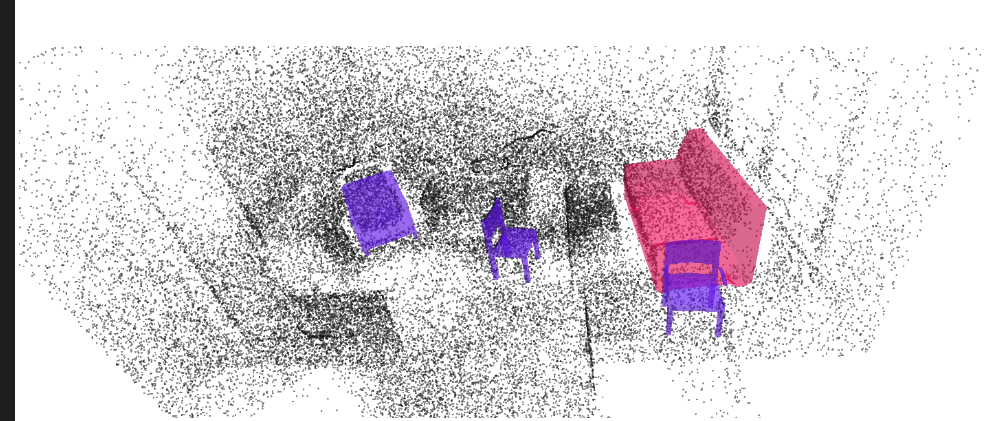

## diff

In [11]:
data_root = "/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA"
json_version = "json_files_v5"
traj_file = None

scene_name = "scene0517_01"

# LAYOUT_VIS=True
LAYOUT_VIS=False

MESH_VIS=True
MESH_PRED_VIS=False
MESH_VIS=False
MESH_PRED_VIS=True

# SEGPCD_VIS=True
# COMPLETE_PCD_VIS=False
SEGPCD_VIS=False
COMPLETE_PCD_VIS=True

M = 50000

vis_data = []
mesh_paths = []

if COMPLETE_PCD_VIS:
    pcd_path = os.path.join(data_root,"ScanARCW/complete_pcd/{}/{}.txt".format(scene_name,scene_name))
    data = np.loadtxt(pcd_path)
    N = data.shape[0]
    data = data[np.random.choice(N, M, replace=False), :]
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]
    complete_pcd = go.Scatter3d(x=x, y=y, z=z, 
            mode='markers',     
            marker=dict(
                size=0.8,  # Adjust the size of the markers here
                color=pcd_color  # Set the color you want (e.g., light blue)
            ),
            name="scene points")
    vis_data.append(complete_pcd)
        

# json_file = "/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/json_files_v2/{}.json".format(scene_name)
json_file = os.path.join(data_root,"ScanARCW",json_version,"{}.json".format(scene_name))

with open(json_file, 'r') as file:
    raw_json = json.load(file)
for scene_id in raw_json.keys():
    instances_data = raw_json[scene_id]["instances"]
    for instance_id in instances_data.keys():
        instance_data = instances_data[instance_id]
        if not instance_data:
            print("The dictionary is empty.")
            continue
        if instance_data['category_name'] == "layout" and (not LAYOUT_VIS):
            print("layout is skipped!")
            continue
        gt_translation_c2w = np.array(instance_data["gt_translation_c2w"]) # 3,
        mesh_path = os.path.join(data_root,instance_data["gt_scaled_canonical_mesh"])
        if instance_data.get("gt_rotation_quat_xyzw_c2w",False):
            print(mesh_path)
            gt_rotation_mat_c2w = quaternion_list2rotmat(instance_data["gt_rotation_quat_xyzw_c2w"],format="xyzw")
            if instance_data['category_id'] in ["1","2","3","4"]:
                print(instance_data['category_id'])
                gt_rotation_mat_c2w = quaternion_list2rotmat(instance_data["gt_rotation_quat_xyzw_c2w"],format="wxyz")
        elif instance_data.get("gt_rotation_quat_wxyz_c2w",False):
            print(mesh_path)
            gt_rotation_mat_c2w = quaternion_list2rotmat(instance_data["gt_rotation_quat_wxyz_c2w"])
        else:
            print("skipped!")
            continue
        
        # mesh = mesh_load(mesh_path)
        mesh_paths.append(mesh_path)
        mesh = trimesh.load(mesh_path)
        basename = os.path.basename(os.path.dirname(mesh_path))
        mesh_normalied, scale, centers = BoundingCubeNormalization(mesh,buffer=1.03)
        mesh = mesh_apply_rts(mesh, mesh_name=basename, rotation_mat_c2w=gt_rotation_mat_c2w, translation_c2w=gt_translation_c2w, scale_c2w=None)
        if MESH_VIS:
            vis_data.append(mesh)
        
        
        # 加载gt mesh计算normal参数然后反向加载到重建结果上再加变换回场景
        if basename in all_list_diff.keys():
            cat, mesh_pred_path = all_list_diff[basename]
            mesh_pred = trimesh.load(mesh_pred_path)
            mesh_pred_denormalized = BoundingCubeDeNormalization(mesh_pred, scale, centers)
            mesh_pred_denormalized = plotly_mesh3d_to_trimesh(mesh_pred_denormalized)
            mesh_pred_denormalized = mesh_apply_rts(mesh_pred_denormalized, mesh_name="pred_"+basename, rotation_mat_c2w=gt_rotation_mat_c2w, translation_c2w=gt_translation_c2w, scale_c2w=None)
            mesh_pred_denormalized['color'] = cat2color_map[cat]
            if MESH_PRED_VIS:
                vis_data.append(mesh_pred_denormalized)

        if SEGPCD_VIS:
            try:
                seg_pcd_path = os.path.join(data_root,instance_data["segmented_cloud"])
                seg_pcd = load_pcd_vis( seg_pcd_path, sub_sample=int( M/len(instances_data.keys()) ) )
                seg_pcd.name = "pcd_{}".format(instance_id)
                seg_pcd['color'] = pcd_color
                vis_data.append(seg_pcd)
            except Exception as e:
                print(e)
                continue
        # break
        # pcd_meshcoord = (np.linalg.inv(gt_rotation_mat_c2w) @ (pcd_world - gt_translation_c2w[np.newaxis, :]).T).T

layout = go.Layout(scene=dict(
        aspectmode='data',  # Set the aspect ratio to 'cube' for equal scales
        xaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, title=''),
        yaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, title=''),
        zaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, title=''),
    ),)

fig = go.Figure(data=vis_data, layout=layout)
# fig.show()
# pio.write_html(fig, "scene0248_00diff.html")

layout is skipped!
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/02933112/1c898677c5b4291c847857e42f50ec6e_scene0517_01_ins_1/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/04379243/28f3844a7a3d37399c0ca344f487323e_scene0517_01_ins_2/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/03001627/6b95ac6189a395d3fa8cf35dd917fad6_scene0517_01_ins_3/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/02933112/5d8c63fce0f30a46f251828d7c328331_scene0517_01_ins_4/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/03001627/297d3e472bf3198fb99cbd993f914184_scene0517_01_ins_5/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/

In [ ]:
fig.show()

## ddit

# scene0188_00

## diff

In [10]:
data_root = "/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA"
json_version = "json_files_v5"
traj_file = None

scene_name = "scene0188_00"

# LAYOUT_VIS=True
LAYOUT_VIS=True

MESH_VIS=True
MESH_PRED_VIS=False
MESH_VIS=False
MESH_PRED_VIS=True

# SEGPCD_VIS=True
# COMPLETE_PCD_VIS=False
SEGPCD_VIS=True
COMPLETE_PCD_VIS=False

M = 20000

vis_data = []
mesh_paths = []

if COMPLETE_PCD_VIS:
    pcd_path = os.path.join(data_root,"ScanARCW/complete_pcd/{}/{}.txt".format(scene_name,scene_name))
    data = np.loadtxt(pcd_path)
    N = data.shape[0]
    data = data[np.random.choice(N, M, replace=False), :]
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]
    complete_pcd = go.Scatter3d(x=x, y=y, z=z, 
            mode='markers',     
            marker=dict(
                size=0.8,  # Adjust the size of the markers here
                color=pcd_color  # Set the color you want (e.g., light blue)
            ),
            name="scene points")
    vis_data.append(complete_pcd)
        

# json_file = "/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/json_files_v2/{}.json".format(scene_name)
json_file = os.path.join(data_root,"ScanARCW",json_version,"{}.json".format(scene_name))

with open(json_file, 'r') as file:
    raw_json = json.load(file)
for scene_id in raw_json.keys():
    instances_data = raw_json[scene_id]["instances"]
    for instance_id in instances_data.keys():
        instance_data = instances_data[instance_id]
        if not instance_data:
            print("The dictionary is empty.")
            continue
        if (instance_data['category_name'] in ["layout","window","door"]):
            if SEGPCD_VIS:
                seg_pcd_path = os.path.join(data_root,instance_data["segmented_cloud"])
                seg_pcd = load_pcd_vis( seg_pcd_path, sub_sample=int( M/len(instances_data.keys()) ) )
                seg_pcd.name = "pcd_{}".format(instance_id)
                # seg_pcd['color'] = pcd_color
                vis_data.append(seg_pcd)

        gt_translation_c2w = np.array(instance_data["gt_translation_c2w"]) # 3,
        mesh_path = os.path.join(data_root,instance_data["gt_scaled_canonical_mesh"])
        if instance_data.get("gt_rotation_quat_xyzw_c2w",False):
            print(mesh_path)
            gt_rotation_mat_c2w = quaternion_list2rotmat(instance_data["gt_rotation_quat_xyzw_c2w"],format="xyzw")
            if instance_data['category_id'] in ["1","2","3","4"]:
                print(instance_data['category_id'])
                gt_rotation_mat_c2w = quaternion_list2rotmat(instance_data["gt_rotation_quat_xyzw_c2w"],format="wxyz")
        elif instance_data.get("gt_rotation_quat_wxyz_c2w",False):
            print(mesh_path)
            gt_rotation_mat_c2w = quaternion_list2rotmat(instance_data["gt_rotation_quat_wxyz_c2w"])
        else:
            print("skipped!")
            continue
        
        # mesh = mesh_load(mesh_path)
        mesh_paths.append(mesh_path)
        mesh = trimesh.load(mesh_path)
        basename = os.path.basename(os.path.dirname(mesh_path))
        mesh_normalied, scale, centers = BoundingCubeNormalization(mesh,buffer=1.03)
        mesh = mesh_apply_rts(mesh, mesh_name=basename, rotation_mat_c2w=gt_rotation_mat_c2w, translation_c2w=gt_translation_c2w, scale_c2w=None)
        if MESH_VIS:
            vis_data.append(mesh)
        
        
        # 加载gt mesh计算normal参数然后反向加载到重建结果上再加变换回场景
        if basename in all_list_diff.keys():
            cat, mesh_pred_path = all_list_diff[basename]
            mesh_pred = trimesh.load(mesh_pred_path)
            mesh_pred_denormalized = BoundingCubeDeNormalization(mesh_pred, scale, centers)
            mesh_pred_denormalized = plotly_mesh3d_to_trimesh(mesh_pred_denormalized)
            mesh_pred_denormalized = mesh_apply_rts(mesh_pred_denormalized, mesh_name="pred_"+basename, rotation_mat_c2w=gt_rotation_mat_c2w, translation_c2w=gt_translation_c2w, scale_c2w=None)
            mesh_pred_denormalized['color'] = cat2color_map[cat]
            if MESH_PRED_VIS:
                vis_data.append(mesh_pred_denormalized)

            if SEGPCD_VIS:
                seg_pcd_path = os.path.join(data_root,instance_data["segmented_cloud"])
                seg_pcd = load_pcd_vis( seg_pcd_path, sub_sample=int( M/len(instances_data.keys()) ) )
                seg_pcd.name = "pcd_{}".format(instance_id)
                # seg_pcd['color'] = pcd_color
                vis_data.append(seg_pcd)
        # break
        # pcd_meshcoord = (np.linalg.inv(gt_rotation_mat_c2w) @ (pcd_world - gt_translation_c2w[np.newaxis, :]).T).T

layout = go.Layout(scene=dict(
        aspectmode='data',  # Set the aspect ratio to 'cube' for equal scales
        xaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, title=''),
        yaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, title=''),
        zaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, title=''),
    ),
    showlegend=False
    )

fig = go.Figure(data=vis_data, layout=layout)
# fig.show()
# pio.write_html(fig, "scene0248_00diff.html")

/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/0/0000_scene0188_00_ins_0/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/02933112/1b212b67e5eb90f4da5feafe6f1c8fc_scene0188_00_ins_1/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/02933112/1b212b67e5eb90f4da5feafe6f1c8fc_scene0188_00_ins_2/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/02933112/1b212b67e5eb90f4da5feafe6f1c8fc_scene0188_00_ins_3/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/04379243/af0206602e75c8bbdc6a693174c70feb_scene0188_00_ins_4/model_canonical.obj
/home/wiss/lhao/storage/user/hjp/ws_dditnach/DeepImplicitTemplates/DATA/ScanARCW/canonical_mesh/04379243/af0206602e75c8bbdc6a693174c70feb_scene0188_00_in

In [12]:
pio.write_html(fig, "scene0188_00diff.html")
# fig.show()

## ddit

# DEV

In [7]:
# 第二个代码块：获取第一个图表的当前视角


# 获取当前图表的布局
fig1_data = pio.to_json(fig)
fig1_layout = pio.from_json(fig1_data)['layout']

# 获取当前视角
camera = fig1_layout['scene']['camera']
print(camera)

layout.scene.Camera()


In [ ]:
# 设置固定视角
camera = dict(
    eye=dict(x=1.25, y=1.25, z=1.25)  # 调整 x, y, z 值以改变视角
)

fig.update_layout(scene=dict(camera=camera))

显示图表
fig.show()

In [7]:
pio.write_html(fig, "scene0248_00ddit.html")